# Fake data generator

In [ ]:
pip install aitextgen

     |████████████████████████████████| 572 kB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 87 kB 8.1 MB/s  eta 0:00:01
     |████████████████████████████████| 527 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 129.9 MB 864 kB/s eta 0:00:01
     |████████████████████████████████| 397 kB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 952 kB 364 kB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 134 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 574 kB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 289 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 402 kB/s eta 0:00:01
     |████████████████████████████████| 156 kB

In [ ]:
pip install Faker

     |████████████████████████████████| 1.5 MB 4.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from aitextgen.TokenDataset import TokenDataset
from aitextgen.tokenizers import train_tokenizer
from aitextgen.utils import GPT2ConfigCPU
from aitextgen import aitextgen
from faker import Faker
from random import shuffle, sample, randint, random
import ast
import re


class artificial_data(object):

    def __init__(self):
        # Train a data2text model to generate artificial description of project on the website
        file_name = 'dataset_des.txt'
        self.ai_text_generator(file_name)
        # Load the trained model
        self.ai_text = aitextgen(model_folder="trained_model", tokenizer_file="aitextgen.tokenizer.json")

        # Use Faker package to generate fake users' information
        self.fake = Faker()

        # Mask users' features
        all_user_features = pd.read_csv('user_feature.csv',index_col=0)
        all_user_features = self.user_feature_mask(all_user_features)
        all_user_features = self.clean_all_user_features(all_user_features)
        all_user_features.to_csv('fake_all_user_features.csv')

        # Mask users' activities features
        # Join the users' activities datasets into one dataframe as match_df
        datasets_list = ['top_click_all.csv','visits_30_user.csv','course_enrolments.csv','order_info.csv']
        match_df = self.concat_match_df(datasets_list,all_user_features)
        match_df = self.match_df_mask(match_df)
        match_df.to_csv('match_df.csv')



    def ai_text_generator(self,file_name):
        # Train a custom BPE Tokenizer on the downloaded text
        # This will save one file: `aitextgen.tokenizer.json`, which contains the
        # information needed to rebuild the tokenizer.
        train_tokenizer(file_name)
        tokenizer_file = "aitextgen.tokenizer.json"

        # GPT2ConfigCPU is a mini variant of GPT-2 optimized for CPU-training
        config = GPT2ConfigCPU()

        # Instantiate aitextgen using the created tokenizer and config
        ai = aitextgen(tokenizer_file=tokenizer_file, config=config)

        # Build datasets for training by creating TokenDatasets,
        # which automatically processes the dataset with the appropriate size.
        data = TokenDataset(file_name, tokenizer_file=tokenizer_file, block_size=64)

        # Train the model. It will save pytorch_model.bin periodically and after completion to the `trained_model` folder.
        # On a 2019 Macbook Pro, this took ~50 minutes to run.
        ai.train(data, batch_size=8, num_steps=50000, generate_every=5000, save_every=5000)
        return None



    def user_feature_mask(self,all_user_features):
        # fake username of the email address
        all_user_features['email'] = [self.fake.user_name()+ '@' + all_user_features['email'].values[i].split('@')[1]
                                    for i in range(0,all_user_features.shape[0])]

        # fake username, first_name, last_name
        all_user_features['username'] = [self.fake.user_name() for _ in range(0,all_user_features.shape[0])]
        all_user_features['first_name'] = [self.fake.first_name() for _ in range(0,all_user_features.shape[0])]
        all_user_features['last_name'] = [self.fake.last_name() for _ in range(0,all_user_features.shape[0])]
        
        # shuffle and resample company, job_title, education, university, major
        all_user_features['company'] = self.shuffle_list(list(all_user_features['company']))
        all_user_features['job_title'] = sample(list(all_user_features['job_title'])+
                                        list(set(all_user_features['job_title']))+
                                        [self.fake.job() for _ in range(40)],k=all_user_features.shape[0])
        all_user_features['education'] = sample(list(all_user_features['education'])+
                                        list(set(all_user_features['education']))*20,
                                        k=all_user_features.shape[0])
        all_user_features['university'] = sample(list(all_user_features['university'])+
                                        list(set(all_user_features['university']))*5,
                                        k=all_user_features.shape[0])
        all_user_features['major'] = sample(list(all_user_features['major'])+
                                        list(set(all_user_features['major']))*5,
                                        k=all_user_features.shape[0])
        
        # shuffle cols 11 - 40, 42 - 47
        for i in list(range(11,41))+list(range(42,48)):
            all_user_features.iloc[:,i] = self.shuffle_list(list(all_user_features.iloc[:,i]))

        # project_list, randomly append 200 project information in the null rows
        notnull_row_origin = list(all_user_features.loc[all_user_features['project_list'].notnull()].index)
        self.random_project_list(all_user_features,200)
        
        # num_follower, append random num to those users who is appended random project_list on previous step
        notnull_row = list(all_user_features.loc[all_user_features['project_list'].notnull()].index)
        append_row = list(set(notnull_row)-set(notnull_row_origin))
        all_user_features.loc[append_row,'num_follower'] = [randint(1,50) for _ in range(len(append_row))]

        # impact score, append impact score to those users who is appended random project_list on previous step
        # impact score range: 0 - 10
        all_user_features.loc[append_row,'impact_score'] = [random()*10 for _ in range(len(append_row))]
        
        # Turn string into list syntax
        all_user_features[['project_list']] = all_user_features[['project_list']].applymap(self.literal_return)

        return all_user_features


    def shuffle_list(self,df_col):
        shuffle(df_col)
        return df_col

    def random_project_list(self,all_user_features,num):
        # Random num of project in each list (range: 1-10)
        # project id is random number from 0 to 2000
        # project title and description generated by ai text generater, title with max_length 15
        # description with max_length 150
        # programing language is randomly chosen from a list of programing software
        programing = ['Python','R','C++','C','Other','Java',None]
        null_row = list(all_user_features.loc[all_user_features['project_list'].isnull()].index)
        random_append_index = sample(null_row,k = num)
        for i in random_append_index:
            project_num = randint(1,10)
            project_list = []
            for _ in range(project_num):
                info = (randint(0,2000),self.ai_text.generate(1,max_length = 15,return_as_list=True)[0],
                        self.ai_text.generate(1,max_length = 150,return_as_list=True)[0],
                        sample(programing,k=1)[0])
                project_list.append(info)
            all_user_features.loc[i,'project_list'] = str(project_list)
        return None

    def clean_all_user_features(self,all_user_features):
        # Clean the text data and turn them into lower case
        clean_list = ['company','job_title','education','major','university']
        for l in clean_list:
            all_user_features[l] = all_user_features[l].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)).lower())
        return all_user_features

    def literal_return(self,val):
        # Turn the string into list syntax
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError) as e:
            return None



    def concat_match_df(self,datasets_list,all_user_features):
        match_df = pd.DataFrame()
        for file in datasets_list:
            df = pd.read_csv(file, index_col=0)
            match_df = pd.concat([match_df,df],axis=1)

        # Select uid corresponding with all_user_features
        match_df = match_df.loc[list(set(all_user_features.index)&set(match_df.index)),:]

        # Clean the text data
        clean_list = ['all_enrol','all_visits','all_orders']
        for l in clean_list:
            match_df[[l]] = match_df[[l]].applymap(self.str_to_list)
        return match_df

    def str_to_list(self,string):
        # Turn the string into list syntax
        if str(string) not in ['NaN','nan','None']:
            return string.strip('][').split(', ')
        else:
            return None

    def match_df_mask(self,match_df):
        # expand purchase list
        order_num = [randint(200,300) for _ in range(50)]
        shuffle_order = list(set(sample(list(match_df[match_df.all_orders.isnull()].index),k=180)))
        match_df.loc[shuffle_order,'all_orders'] = sample(order_num*5,k=len(shuffle_order))
        match_df.loc[shuffle_order,'purchased_entity'] = match_df.loc[shuffle_order,'all_orders']
        # expand visits list
        shuffle_visit = list(set(sample(list(match_df[match_df.all_visits.isnull()].index),k=320)))
        visit_info = sample(list(match_df[match_df.all_visits.notnull()].index)*10,k=len(shuffle_visit))
        for col in ['url','time','time_period','all_visits']:
            match_df.loc[shuffle_visit,col] = list(match_df.loc[visit_info,col])

        # expand enrollment
        shuffle_enrol = list(set(sample(list(match_df[match_df.all_enrol.isnull()].index),k=170)))
        enrol_info = list(set(match_df[match_df.all_enrol.notnull()]['enrolment']))
        match_df.loc[shuffle_enrol,'enrolment'] = sample(enrol_info*10,k=len(shuffle_enrol))
        match_df.loc[shuffle_enrol,'all_enrol'] = match_df.loc[shuffle_enrol,'enrolment']
        return match_df


In [ ]:
fake_data = artificial_data()

/opt/anaconda3/envs/rqsdk/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/rqsdk/lib/python3.8/site-packages/pandas/core/internals/blocks.py:867: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)


In [62]:
all_user_features = pd.read_csv('fake_all_user_features.csv')
print(all_user_features.info())
all_user_features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   uid                           884 non-null    int64  
 1   email                         884 non-null    object 
 2   username                      884 non-null    object 
 3   first_name                    884 non-null    object 
 4   last_name                     884 non-null    object 
 5   impact_score                  884 non-null    float64
 6   company                       487 non-null    object 
 7   job_title                     488 non-null    object 
 8   education                     131 non-null    object 
 9   university                    172 non-null    object 
 10  major                         160 non-null    object 
 11  num_follower                  884 non-null    float64
 12  communication_services        884 non-null    float64
 13  consu

,uid,email,username,first_name,last_name,impact_score,company,job_title,education,university,...,filter_test,filter_spam,filter_spam_2,project_list,covid_competition,news_competition,property_competition,restaurant_competition,investment_competition,recency
0,678,christopherknight@rmdslab.com,castrochristina,Christopher,Long,40.460932,university of st thomas,NaN,NaN,NaN,...,False,False,False,"[(489, 'RMDS Meetup Speakers Presentations', N...",False,False,False,False,False,0
1,246,cgreene@gmail.com,gtucker,Jennifer,Robbins,29.369300,simon fraser university,ceo,NaN,NaN,...,False,False,False,"[(376, 'Linear Regression Analysis of US Censu...",False,False,True,False,False,0
2,2232,hthomas@gmail.com,zrodriguez,Spencer,Ramos,23.920091,universitas pasundan,theatre stage manager,NaN,NaN,...,False,False,False,"[(884, 'Bank Churn', None, None), (1251, 'Educ...",False,False,False,False,False,0
3,3252,kimjanice@gmail.com,lucashall,Larry,Shah,15.879526,NaN,student,NaN,adler university,...,False,False,False,NaN,False,False,False,False,False,0
4,9174,haroldguerrero@gmail.com,debbiekelley,Craig,Tanner,14.205337,NaN,NaN,less than high school,NaN,...,False,False,False,"[(1100, 'Predicting Recession', None, None), (...",False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,16980,paul80@stthomas.edu,tayala,Nicole,Butler,4.369247,usc,founding director,bachelors degree,NaN,...,False,False,False,"[(808, 'since January 1, 2010, NYSE', 'follows...",False,False,False,False,False,0
880,17046,warderic@hotmail.com,hchapman,Jennifer,Bush,6.972213,NaN,head of marketing operations for brentmark in...,NaN,NaN,...,False,False,False,"[(148, 'and are provisional and are not includ...",False,False,False,False,False,0
881,17064,dwaynemanning@qq.com,robert66,Ronald,Anderson,0.000000,amherst college,NaN,NaN,NaN,...,False,False,False,NaN,False,False,False,False,False,0
882,17100,nicholefloyd@gmail.com,burtoncheryl,David,Garrison,0.000000,NaN,NaN,NaN,NaN,...,False,False,False,NaN,False,False,False,False,False,0


In [63]:
match_df = pd.read_csv('match_df.csv')
print(match_df.info())
match_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               829 non-null    int64  
 1   node              829 non-null    object 
 2   webinar           829 non-null    object 
 3   url               422 non-null    object 
 4   time              422 non-null    float64
 5   time_period       422 non-null    float64
 6   all_visits        422 non-null    object 
 7   enrolment         363 non-null    float64
 8   all_enrol         363 non-null    object 
 9   purchased_entity  254 non-null    float64
 10  all_orders        254 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 71.4+ KB
None


,uid,node,webinar,url,time,time_period,all_visits,enrolment,all_enrol,purchased_entity,all_orders
0,10242,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2052,[],[],NaN,NaN,NaN,NaN,136.0,136.0,250.0,250
2,16392,[],[],NaN,NaN,NaN,NaN,85.0,85.0,208.0,208
3,10248,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2058,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
824,16374,[],[],http://grmds.org/user/login,1.643239e+09,1643238.0,"[""'http://grmds.org/comp/nft?utm_source=email&...",111.0,111.0,265.0,265
825,2040,['/node/524'],['/webinar/An-Introduction-to-the-Data-Resourc...,NaN,NaN,NaN,NaN,108.0,108.0,NaN,NaN
826,10230,"['/node/376', '/node/625', '/node/375']",[],NaN,NaN,NaN,NaN,272.0,272.0,NaN,NaN
827,10236,[],[],http://grmds.org/user/login,1.644367e+09,1644366.0,"[""'http://grmds.org/ds-volunteer-application-f...",111.0,111.0,NaN,NaN


# **User Sim**

In [55]:
pip install pyjarowinkler

In [56]:
from pyjarowinkler import distance   
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
import pandas as pd
import numpy as np
import ast
from ast import literal_eval
from itertools import combinations
import pickle
import warnings
warnings.filterwarnings('ignore')

In [57]:
# Methods for generate similarities
class recom_user(object):
    def __init__(self):
        self.interest_list = ['Fraud_Detection', 'Risk_Scoring', 'Healthcare', 'Internet_Search', 'Marketing_Effectiveness',
                              'Website_Recommendations', 'Image_Recognition', 'Speech_Recognition',
                              'Airline_Route_Planning', 'Price_Analytics', 'Supply_Chain_Optimization',
                              'Talent_Acquisition_Analytics', 'Environment_Analytics', 'Epidemiology',
                              'Social_Policy', 'Evaluation_and_Assessment']
        self.vectorizer = TfidfVectorizer()
        
    def compare(self, info1, info2):
        results = {}
        
        #email extension sim
        results['email_sim'] = self.email_extension(info1['email'], info2['email'])
        
        #University company job_title education major sim
        user_info_list = ['university','company','job_title','education','major']
        for l in user_info_list:
            results[l] = self.simple_text(info1[l], info2[l])
        
        # interest sim
        results['interest_sim'] = self.cos_sim([info1[x] if info1[x] != None else 0 for x in self.interest_list], 
                                               [info2[x] if info2[x] != None else 0 for x in self.interest_list])
        # followers
        results['follower_sim'] = info2['num_follower']

        # impact score
        results['impact_score_sim'] = info2['impact_score']        

        # recency
        results['recency_sim'] = info2['recency']

        # news competition
        competition_list = ['covid_competition','news_competition','property_competition','restaurant_competition',
                            'investment_competition']
        for l in competition_list:
            results[l] = info1[l] & info2[l]

        # project part
        if (info1['project_list']==None or info2['project_list']==None or 
            len(info1['project_list']) ==0 or len(info2['project_list'])==0):
            results['proj_title_sim'],results['proj_des_sim'],results['proj_language_sim'] = None, None, None
            return results
     
        # project title sim
        title_list1 = [x[1] for x in info1['project_list']]
        title_list2 = [x[1] for x in info2['project_list']]
        pairs = list(itertools.product(title_list1, title_list2))
        results['proj_title_sim'] = sum(map(lambda x : self.simple_text(x[0],x[1]), pairs)) / len(pairs)
        
        # project language sim
        lan_list1 = [x[3] for x in info1['project_list'] if x[3] != None]
        lan_list2 = [x[3] for x in info2['project_list'] if x[3] != None]
        if len(lan_list1) == 0 or len(lan_list2) == 0:
            results['proj_language_sim'] = None
        else:
            pairs = list(itertools.product(lan_list1, lan_list2))
            results['proj_language_sim'] = sum(map(lambda x : x[0].lower()==x[1].lower(), pairs)) / len(pairs) * 100
            
        # project description sim
        des_list1 = [x[2] for x in info1['project_list'] if x[2] != None]
        des_list2 = [x[2] for x in info2['project_list'] if x[2] != None]
        if len(des_list1) == 0 or len(des_list2) == 0:
            results['proj_des_sim'] = None
        else:
            results['proj_des_sim'] = self.long_text(des_list1, des_list2)
        
        return results
        
    def email_extension(self,u1,u2):
        # Judge if these two email address have the same suffix
        if u1 in [None,''] or u2 in [None,'']:
            return None
        try:
            return (u1.split('@')[1].split('.')[1] == u2.split('@')[1].split('.')[1]) * 100
        except:
            return None
        
    def simple_text(self,u1,u2):
        if u1 in [None,''] or u2 in [None,'']:
            return None
        #u1 = re.sub(r'[^\w]', '', u1).lower()
        #u2 = re.sub(r'[^\w]', '', u2).lower()
        return distance.get_jaro_distance(u1, u2) * 100
    
    def cos_sim(self,u1,u2):
    #   return cosine_similarity([u1], [u2])[0][0] * 100
        u1 = np.array(u1)
        u2 = np.array(u2)
        # numpy's cosine similarity
        cosine_sim = np.dot(u1,u2) / (np.sqrt(np.dot(u1,u1)) * np.sqrt(np.dot(u2,u2)))
        if np.isnan(cosine_sim):
          return None
        else:
          return cosine_sim * 100
    
    def long_text(self,doc1,doc2):
        # Vectorize long text information and calculate their cosine similarity score
        #vectorizer = TfidfVectorizer()
        vectors = self.vectorizer.fit_transform(doc1+doc2)
        dense = vectors.todense()
        dense1 = dense[:len(doc1)]
        dense2 = dense[len(doc1):]
        pairs = list(itertools.product(dense1, dense2))
        return sum(map(lambda x : cosine_similarity(x[0], x[1])[0][0] , pairs)) / len(pairs) * 100
    
        

In [103]:
# Generate dependent varibles, as matched/unmatched
# Matching or not is decided by wheather or not the users have some common activities:
# Visiting a same project/webinar/course/other pages, Taking a same order...

class user_sim_evaluator(object):
    def __init__(self,n_node, n_webinar,match_file,feature_file):
        match_df = pd.read_csv(match_file,index_col=0)
        all_user_features = pd.read_csv(feature_file,index_col=0)
        all_user_features = self.clean_features(all_user_features)
        match_df = self.clean_match(match_df)
        self.recom = recom_user()
        self.pair_wise, self.common_ids = self.evaluate_all(n_node, n_webinar,all_user_features,match_df) 
        
    def evaluate_all(self, n_node, n_webinar, all_user_features,match_df):
        # Filter out users with at least one visit in project/webinar
        valid_list = match_df[(match_df.node.str.find('/node/')>-1) | (match_df.webinar.str.find('/webinar/')>-1)]
        # Turn the string of node and webinar into list syntax
        valid_list[['node', 'webinar']] = valid_list[['node', 'webinar']].applymap(literal_eval)
        valid_ids = valid_list.index.to_list()
        common_ids = list(set(valid_ids).intersection(all_user_features.index))
        # In case ids are mixed

        # formatting features for evaluation 
        filter = all_user_features.index.isin(common_ids)
        all_features = all_user_features[filter]
        all_features = all_features.where(pd.notnull(all_features), None)
        valid_list = valid_list.where(pd.notnull(valid_list), None)
              

        pair_wise = []
        count = 0
        for tuples in combinations(common_ids, 2):
            count += 1
            r1 = valid_list.loc[tuples[0],:]
            r2 = valid_list.loc[tuples[1],:]
            match = []
            match.append(not set(r1['node'][:n_node]+r1['webinar'][:n_webinar]).isdisjoint(r2['node'][:n_node]+r2['webinar'][:n_webinar]))

            # Checking common in courses, orders, visits
            activities_list = ['all_enrol','all_orders','all_visits']
            for l in activities_list:
              activity_1 = valid_list.loc[tuples[0],l]
              activity_2 = valid_list.loc[tuples[1],l]
              if activity_1 == None or activity_2 ==None:
                match.append(False)
              elif len(set(activity_1)&set(activity_2))>0:
                match.append(True)
              else:
                match.append(False)

            
            # If there is one match, users have common activity
            match = sum(match)
            if match >1: 
                match = 1 
            uinfo_1 = all_features.loc[tuples[0],:]
            uinfo_2 = all_features.loc[tuples[1],:]
            sim_score = self.recom.compare(uinfo_1,uinfo_2)                                                                                            
            pair_wise.append({'user1': tuples[0], 'user2': tuples[1], 'match': match, 'sim_score': sim_score})

        # Create a pickle file to save the data
        with open("pairwise_compare_dict.pickle", "wb",) as myFile:
            pickle.dump(pair_wise, myFile)
    
        return pair_wise, common_ids

    def literal_return(self,val):
        # Turn the string into list syntax
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError) as e:
            return None

    def str_to_list(self,string):
        # Turn the string into list syntax
        if str(string) not in ['NaN','nan','None']:
            return string.strip('][').split(', ')
        else:
            return None

    def clean_features(self,all_user_features):
        # Clean the text data
        all_user_features[['project_list']] = all_user_features[['project_list']].applymap(self.literal_return)
        clean_list = ['company','job_title','education','major','university']
        for l in clean_list:
            all_user_features[l] = all_user_features[l].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)).lower())
        return all_user_features

    def clean_match(self,match_df):
        clean_list = ['all_enrol','all_visits','all_orders']
        for l in clean_list:
            match_df[[l]] = match_df[[l]].applymap(self.str_to_list)
        return match_df


In [104]:
user_sim = user_sim_evaluator(5,3,'match_df.csv','fake_all_user_features.csv') #Numbers up to change

In [105]:
pair_wise = user_sim.pair_wise
len(pair_wise)

30381

In [73]:
i = 0
for n in range(len(pair_wise)):
   i += pair_wise[n]['match']

i/len(pair_wise)
# See how much matches we could get

0.32250419670188607

# **Model retraining and update**

In [89]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 23 11:40:08 2020
@author: jidong
"""
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import numpy as np


class model_retrain(object):
    def __init__(self,final_dict,all_user_features):
        model, res = self.model_retrain_test(final_dict)
        model.to_csv('model_weights.csv')
        res.to_csv('model_accuracy.csv')

        self.recom = recom_user()
        all_user_features = self.clean_features(all_user_features)
        self.user_sim_table = self.update_user_recom_table(all_user_features, model)
        self.user_sim_table.to_csv('user_sim_table.csv')

    def model_retrain_test(self,data):
        for elem in data:
            score = elem['sim_score']
            key_list = score.keys()
            for key in key_list:
                elem[key] = score[key]
            elem.pop('sim_score')
        
        pair_df = pd.DataFrame(data)
        col_name = list(pair_df.columns)[3:]
        
        # Clean the pairwise data
        process_pair_df = pair_df.dropna(thresh = 6)
        process_pair_df = process_pair_df.fillna(0)
        process_pair_df['match'] = pair_df['match'].astype(int)
        x = process_pair_df.iloc[:, 3:].to_numpy()
        y = np.array(process_pair_df['match'])
        
        # Utilize LR model to get the weight of each similarity features
        # Dependent variables are users' match
        # Independent variables are users' similarity scores
        model = LogisticRegression(solver='liblinear', multi_class='ovr')
        kfold = model_selection.KFold(n_splits=10)
        cv = model_selection.cross_validate(model, x, y, cv=kfold, scoring='accuracy', return_estimator=True)
        cv_results = cv['test_score']
        best_model = cv['estimator'][np.argmax(cv_results)]
        
        # Generate results df
        results_table = pd.DataFrame()
        results_table['accuracy'] = cv_results
        results_table['timestamp'] = pd.Timestamp.today()
        best_model.fit(x,y)
        model_para = np.absolute(best_model.coef_[0])
        model_para = model_para / model_para.sum()
        model_para = pd.DataFrame(zip(col_name, model_para), columns = ['features','weights'])
        model_para['timestamp'] = pd.Timestamp.today()
            
        return model_para, results_table

        # Periodically update the recommendation score table
        # Calculate total similarity score of each user by using the weights in LR model
    def update_user_recom_table(self,data, model):
        results = []
        count = 0
        user_list = data.index.to_list()
        weight = np.array(model['weights'])
        for user1 in user_list:
            sim_user = []
            for user2 in user_list:
                if user1 != user2:
                    count += 1
                    if count%100000 == 0:
                        print(count)
                    compare = self.recom.compare(data.loc[user1,:], data.loc[user2,:])
                    compare = {key:0 if str(value) in ['nan','None','NaN'] else value for key,value in compare.items()}
                    score = np.dot(np.array(list(compare.values())),weight)
                    sim_user.append({'user': user1, 'sim_user': user2, 'sim_score':score})
            sim_user = sorted(sim_user, key = lambda x: x['sim_score'], reverse = True)[:10] # Could be 50
            results.extend(sim_user)
        results = pd.DataFrame(results)
        return results

    def clean_features(self,all_user_features):
        # Clean the text data
        all_user_features[['project_list']] = all_user_features[['project_list']].applymap(self.literal_return)
        clean_list = ['company','job_title','education','major','university']
        for l in clean_list:
            all_user_features[l] = all_user_features[l].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)).lower())
        return all_user_features
    
    def literal_return(self,val):
        # Turn the string into list syntax
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError) as e:
            return None

In [93]:
final_dict = pd.read_pickle('pairwise_compare_dict.pickle')
all_user_features = pd.read_csv('fake_all_user_features.csv',index_col=0)
retrain = model_retrain(final_dict, all_user_features)

100000
200000
300000
400000
500000
600000
700000


In [94]:
user_sim_table = retrain.user_sim_table
user_sim_table

,Unnamed: 0,user,sim_user,sim_score
0,0,678,6552,1.517091
1,1,678,3396,1.451002
2,2,678,16890,1.433840
3,3,678,9990,1.423084
4,4,678,8964,1.217707
...,...,...,...,...
8835,8835,17118,9174,0.511951
8836,8836,17118,9120,0.507265
8837,8837,17118,16230,0.497397
8838,8838,17118,492,0.492900


# **Evaluation**

In [123]:
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import sklearn.metrics as metrics
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class evaluation(object):
  def __init__(self, filename):
    final_dict = pd.read_pickle(filename)
    X, y, model = self.cross_validate(final_dict)
    self.y_pred_prob_test, self.y_pred = self.model_evaluate(X,y,model)


  def cross_validate(self,data):
    for elem in data:
      score = elem['sim_score']
      key_list = score.keys()
      for key in key_list:
          elem[key] = score[key]
      elem.pop('sim_score')

    pair_df = pd.DataFrame(data)
    col_name = list(pair_df.columns)[3:]

    process_pair_df = pair_df.dropna(thresh = 6)
    process_pair_df = process_pair_df.fillna(0)
    process_pair_df['match'] = pair_df['match'].astype(int)
    X = process_pair_df.iloc[:, 3:].to_numpy()
    y = np.array(process_pair_df['match'])

    model = LogisticRegression(solver='liblinear', multi_class='ovr')
    kfold = model_selection.KFold(n_splits=10)
    cv = model_selection.cross_validate(model, X, y, cv=kfold, scoring='accuracy', return_estimator=True)
    cv_results = cv['test_score']
    best_model = cv['estimator'][np.argmax(cv_results)]
    print('Cross validation results',cv_results.mean())

    return X,y,model

  def model_evaluate(self,X,y,model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    model.fit(X_train,y_train)
    y_pred_prob_test = model.predict_proba(X_test)
    y_pred = model.predict(X_test)

    #Confusion Matrix
    confusion_matrix_census=sklearn.metrics.confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize=None)
    tn, fp, fn, tp = confusion_matrix_census.ravel()
    print(confusion_matrix_census)

    #Precision and Recall
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    print('Precision is ',precision,' , Recall is ',recall)

    #f1 score
    f1_score_cen=sklearn.metrics.f1_score(y_test, y_pred,average='binary')
    f1_score_cal=2*precision*recall/(precision+recall)
    print('built-in f1 score is ',f1_score_cen)
    print('calculated f1 score is ',f1_score_cal)



    #Accuracy score and AUC score
    accuracy=accuracy_score(y_test, y_pred)
    print('Accuracy score is ',accuracy)

    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)
    print('AUC score is ',roc_auc)


    #ROC
    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    return y_pred_prob_test, y_pred


Cross validation results 0.6772618240685441
[[6782   28]
 [3195   21]]
Precision is  0.42857142857142855  , Recall is  0.0065298507462686565
built-in f1 score is  0.012863705972434915
calculated f1 score is  0.012863705972434915
Accuracy score is  0.6785358069020546
AUC score is  0.5570836392559961


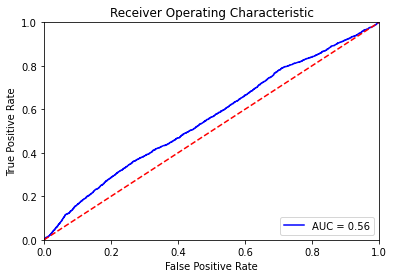

In [124]:
evaluate = evaluation('pairwise_compare_dict.pickle')


In [125]:
y_pred_prob = evaluate.y_pred_prob_test
y_prob = []
for num in range(len(y_pred_prob)):
  y_prob.append(y_pred_prob[num][1])

results = pd.Series(y_prob) 
y_pred = results > 0.40  # Change threshold here
y_pred = y_pred*1

y_pred.value_counts()

0    9419
1     607
dtype: int64